In [57]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import mplcyberpunk

import matplotlib.font_manager as fm
font_path = fm.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc').get_name()

import seaborn as sns
sns.set_theme(style="darkgrid", palette="Set2", context="paper")

plt.style.use("cyberpunk")
plt.rcParams['font.sans-serif'] = font_path

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

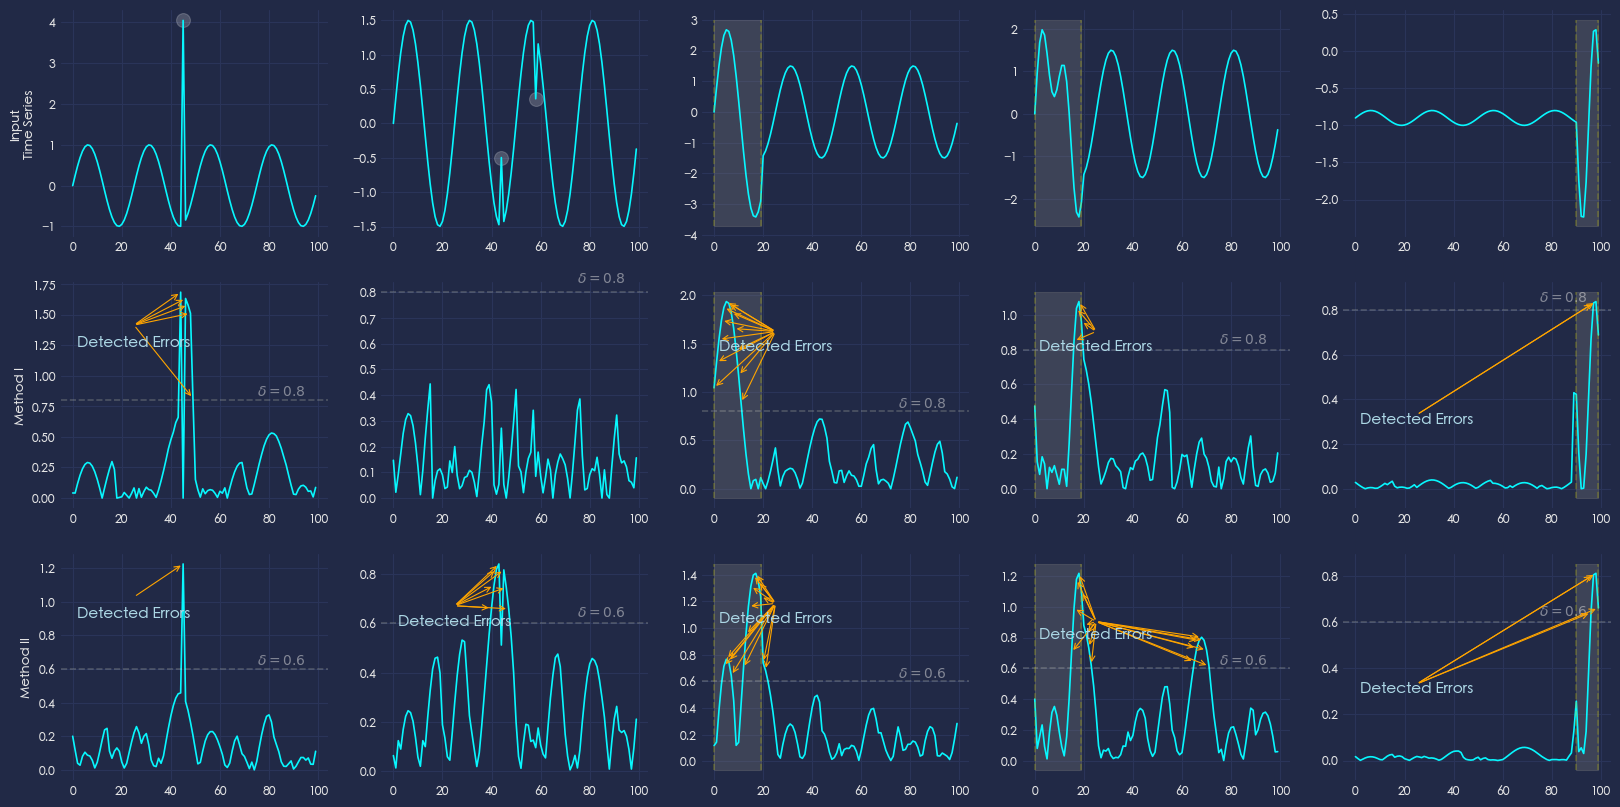

In [69]:
# 1
from dataclasses import dataclass, field

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


@dataclass
class TS:
    data: np.ndarray = field(init=False)
    data_size: int = field(init=False)
    noise_index: list[int] = field(init=False)
    reconstruction_error: list[float] = field(init=False)
    ylim: float = field(init=False, default=0)

    def generate_data(
        self,
        cycles: int,
        frequency: float,
        shift: float = 0,
        amplitude: float = 1,
        resolution: int = 100,
    ):
        self.data_size = resolution

        length = np.pi * 2 * cycles * frequency
        step_size = length / self.data_size

        self.data = shift + amplitude * np.sin(np.arange(0, length, step_size))

    def generate_add_noise(self, indexes: list[int], noise: list[float]):
        try:
            assert len(indexes) == len(noise)

        except AssertionError as e:
            print("The length of indexes and noise should be the same.")
            raise

        self.noise_index = indexes
        self.data[self.noise_index] += noise

    def plot_noise(self, ax):
        if (
            len(self.noise_index) > 1
            and abs(np.diff(np.asarray(self.noise_index))).max() < 2
        ):
            y = [ax.get_ylim()[0], ax.get_ylim()[1]]

            self.ylim = (
                min(ax.get_ylim()[1], self.ylim) if self.ylim > 0 else ax.get_ylim()[1]
            )

            x1 = self.noise_index[0]
            x2 = self.noise_index[-1]

            ax.plot([x1, x1], y, "y--", alpha=0.3)
            ax.plot([x2, x2], y, "y--", alpha=0.3)
            ax.fill_betweenx(y, x1, x2, color="gray", alpha=0.3)

        else:
            ax.scatter(
                self.noise_index,
                self.data[self.noise_index],
                color="white",
                alpha=0.2,
                s=100,
            )

    def plot_data_with_noise(self, ax):
        ax.plot(self.data)
        self.plot_noise(ax)

    def cal_reconstruction_error(self, reg):
        poly = PolynomialFeatures(degree=30)
        index = np.arange(0, self.data_size // 20, 0.05).reshape(-1, 1)
        poly_features = poly.fit_transform(index)

        reg = reg
        X_train, X_test, y_train, y_test = train_test_split(
            poly_features, self.data, test_size=0.8
        )
        pred = reg.fit(X_train, y_train).predict(poly_features)

        self.reconstruction_error = abs(pred - self.data) / 3

    def plot_error(self, threshold, ax):
        ax.axhline(
            y=threshold,
            color="lightyellow",
            linestyle="--",
            alpha=0.2,
        )

        ax.text(
            self.data_size * 3 / 4,
            threshold * 1.05,
            rf"$\delta = {threshold}$",
            fontsize=10,
            alpha=0.5,
        )

        self.ylim = (
            min(ax.get_ylim()[1], self.ylim) if self.ylim > 0 else ax.get_ylim()[1]
        )

        for x, y in zip(list(range(len(self.data))), self.reconstruction_error):
            if y > threshold:
                ax.annotate(
                    "",
                    xy=(x, y),
                    xytext=(self.data_size / 4, self.ylim * 0.8),
                    arrowprops=dict(arrowstyle="->", color="orange"),
                )

        if max(self.reconstruction_error) > threshold:
            ax.annotate(
                "Detected Errors",
                xy=(self.data_size / 4, self.ylim * 0.8),
                xytext=(self.data_size / 4, self.ylim * 0.7),
                fontsize=11,
                color="lightblue",
                ha="center",
            )

    def plot_error_with_noise(self, reg, threshold, ax):
        self.cal_reconstruction_error(reg=reg)

        ax.plot(self.reconstruction_error)

        self.plot_error(threshold, ax)

        if (
            len(self.noise_index) > 1
            and abs(np.diff(np.asarray(self.noise_index))).max() < 2
        ):
            self.plot_noise(ax)


fig, axes = plt.subplots(3, 5, figsize=(20, 10))


def plot_col(
    cycles,
    frequency,
    shift,
    amplitude,
    resolution,
    noise_index,
    noise_values,
    reg1,
    reg2,
    c,
    axes,
):
    ts = TS()
    ts.generate_data(cycles, frequency, shift, amplitude, resolution)
    ts.generate_add_noise(noise_index, noise_values)
    ts.plot_data_with_noise(axes[0, c])
    ts.plot_error_with_noise(reg1, 0.8, axes[1, c])
    ts.plot_error_with_noise(reg2, 0.6, axes[2, c])


plot_col(
    4,
    1,
    0,
    1,
    100,
    [45],
    [5],
    AdaBoostRegressor(n_estimators=1000),
    RandomForestRegressor(n_estimators=1000, max_depth=10),
    0,
    axes,
)
plot_col(
    4,
    1,
    0,
    1.5,
    100,
    [44, 58],
    [1, -1],
    AdaBoostRegressor(n_estimators=1000),
    RandomForestRegressor(n_estimators=1000, max_depth=10),
    1,
    axes,
)
plot_col(
    4,
    1,
    0,
    1.5,
    100,
    list(range(20)),
    1.5 * np.sin(np.arange(0, 2 * np.pi, 2 * np.pi / 20)) - np.arange(0, 1, 0.05),
    AdaBoostRegressor(n_estimators=1000),
    RandomForestRegressor(n_estimators=1000, max_depth=10),
    2,
    axes,
)
plot_col(
    4,
    1,
    0,
    1.5,
    100,
    list(range(20)),
    np.sin(np.arange(0, 4 * np.pi, 4 * np.pi / 20)),
    AdaBoostRegressor(n_estimators=1000),
    RandomForestRegressor(n_estimators=1000, max_depth=10),
    3,
    axes,
)
plot_col(
    4,
    1,
    -0.9,
    0.1,
    100,
    list(range(90, 100)),
    -1.3 * np.sin(np.arange(0, 2 * np.pi, 2 * np.pi / 10)),
    AdaBoostRegressor(n_estimators=1000),
    RandomForestRegressor(n_estimators=1000, max_depth=10),
    4,
    axes,
)

axes[0, 0].set_ylabel(f"Input\nTime Series")
axes[1, 0].set_ylabel(f"Method I")
axes[2, 0].set_ylabel(f"Method II")

plt.savefig("_.jpg")

plt.show()

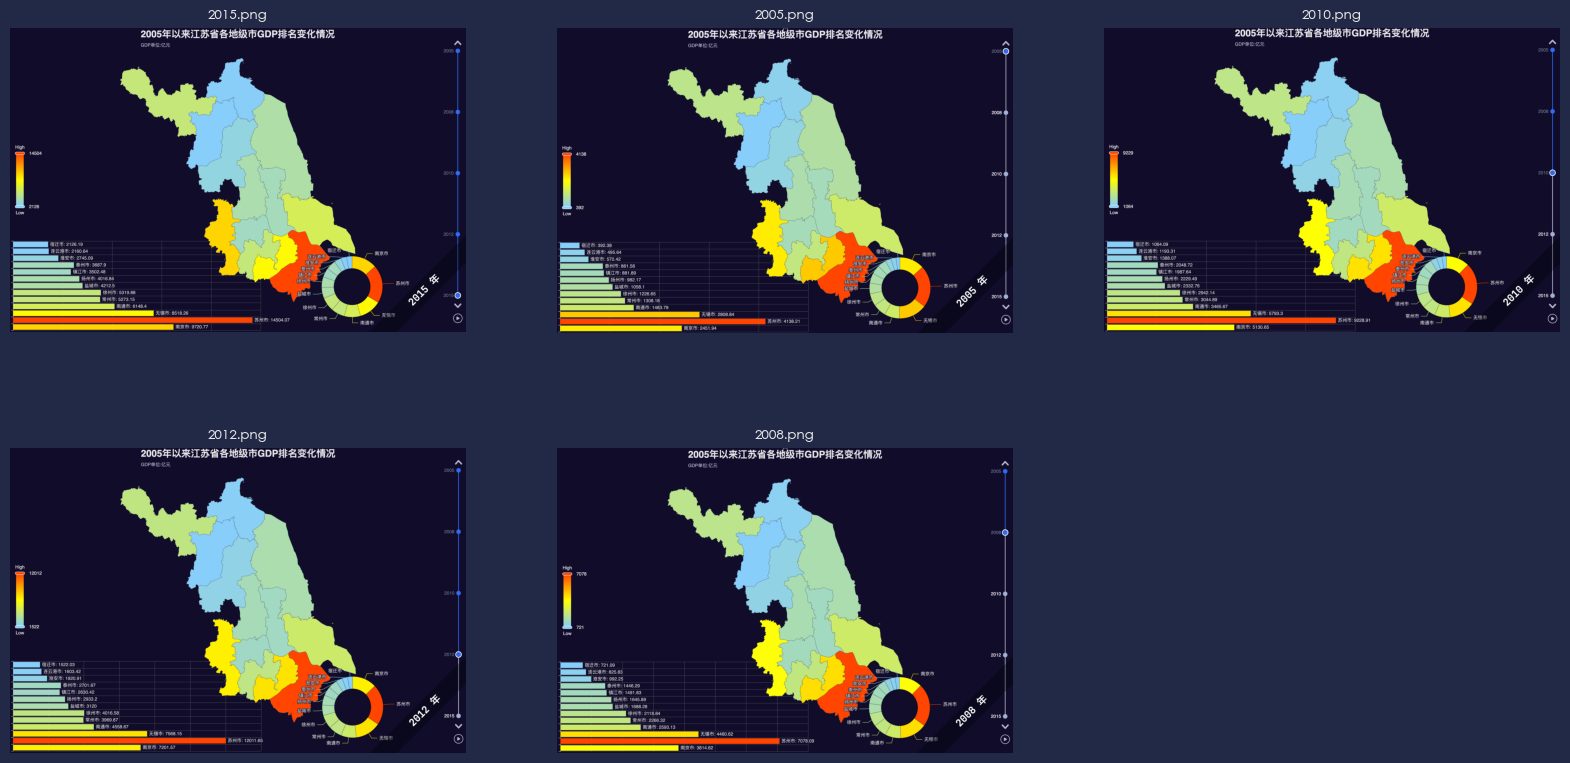

In [3]:
# 2
import json

import pyecharts.options as opts
from pyecharts.globals import ThemeType
from pyecharts.commons.utils import JsCode
from pyecharts.charts import Timeline, Grid, Bar, Map, Pie

with open("jiangsu.json", "r", encoding="utf-8") as file:
    text = file.read()

data = json.loads(text)


def get_year_chart(year: int):
    map_data = [
        [[x["name"], x["value"]] for x in d["data"]] for d in data if d["time"] == year
    ][0]
    min_data, max_data = (
        min([d[1][0] for d in map_data]),
        max([d[1][0] for d in map_data]),
    )
    map_chart = (
        Map()
        .add(
            series_name="",
            data_pair=map_data,
            maptype="江苏",
            label_opts=opts.LabelOpts(is_show=False),
            is_map_symbol_show=False,
            itemstyle_opts={
                "normal": {"areaColor": "#323c48", "borderColor": "#404a59"},
                "emphasis": {
                    "label": {"show": Timeline},
                    "areaColor": "rgba(255,255,255, 0.5)",
                },
            },
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="2005年以来江苏省各地级市GDP排名变化情况",
                subtitle="GDP单位:亿元",
                pos_left="center",
                pos_top="top",
                title_textstyle_opts=opts.TextStyleOpts(
                    font_size=25, color="rgba(255,255,255, 0.9)"
                ),
            ),
            tooltip_opts=opts.TooltipOpts(
                is_show=True,
                formatter=JsCode(
                    """function(params) {
                    if ('value' in params.data) {
                        return params.data.value[2] + ': ' + params.data.value[0];
                    }
                }"""
                ),
            ),
            visualmap_opts=opts.VisualMapOpts(
                is_calculable=True,
                dimension=0,
                pos_left="10",
                pos_top="center",
                range_text=["High", "Low"],
                range_color=["lightskyblue", "yellow", "orangered"],
                textstyle_opts=opts.TextStyleOpts(color="#ddd"),
                min_=min_data,
                max_=max_data,
            ),
        )
    )

    bar_x_data = [x[0] for x in map_data]

    bar_y_data = [{"name": x[0], "value": x[1][0]} for x in map_data]
    bar = (
        Bar()
        .add_xaxis(xaxis_data=bar_x_data)
        .add_yaxis(
            series_name="",
            yaxis_index=1,
            y_axis=bar_y_data,
            label_opts=opts.LabelOpts(
                is_show=True, position="right", formatter="{b}: {c}"
            ),
        )
        .reversal_axis()
        .set_global_opts(
            xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show=False)),
            yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show=False)),
            tooltip_opts=opts.TooltipOpts(is_show=False),
            visualmap_opts=opts.VisualMapOpts(
                is_calculable=True,
                dimension=0,
                pos_left="10",
                pos_top="center",
                range_text=["High", "Low"],
                range_color=["lightskyblue", "yellow", "orangered"],
                textstyle_opts=opts.TextStyleOpts(color="#ddd"),
                min_=min_data,
                max_=max_data,
            ),
            graphic_opts=[
                opts.GraphicGroup(
                    graphic_item=opts.GraphicItem(
                        rotation=JsCode("Math.PI / 4"),
                        bounding="raw",
                        right=110,
                        bottom=110,
                        z=100,
                    ),
                    children=[
                        opts.GraphicRect(
                            graphic_item=opts.GraphicItem(
                                left="center", top="center", z=100
                            ),
                            graphic_shape_opts=opts.GraphicShapeOpts(
                                width=400, height=50
                            ),
                            graphic_basicstyle_opts=opts.GraphicBasicStyleOpts(
                                fill="rgba(0,0,0,0.3)"
                            ),
                        ),
                        opts.GraphicText(
                            graphic_item=opts.GraphicItem(
                                left="center", top="center", z=100
                            ),
                            graphic_textstyle_opts=opts.GraphicTextStyleOpts(
                                text=f"{str(year)} 年",
                                font="bold 26px Microsoft YaHei",
                                graphic_basicstyle_opts=opts.GraphicBasicStyleOpts(
                                    fill="#fff"
                                ),
                            ),
                        ),
                    ],
                )
            ],
        )
    )

    pie_data = [[x[0], x[1][0]] for x in map_data]
    percent_sum = sum([x[1][1] for x in map_data])
    rest_value = 0
    for d in map_data:
        rest_percent = 100.0
        rest_percent = rest_percent - percent_sum
        rest_value = d[1][0] * (rest_percent / d[1][1])
    pie_data.append(["其他省份", rest_value])
    pie = (
        Pie()
        .add(
            series_name="",
            data_pair=pie_data,
            radius=["12%", "20%"],
            center=["75%", "85%"],
            itemstyle_opts=opts.ItemStyleOpts(
                border_width=1, border_color="rgba(0,0,0,0.3)"
            ),
        )
        .set_global_opts(
            tooltip_opts=opts.TooltipOpts(is_show=True, formatter="{b} {d}%"),
            legend_opts=opts.LegendOpts(is_show=False),
        )
    )

    grid_chart = (
        Grid()
        .add(
            bar,
            grid_opts=opts.GridOpts(
                pos_left="10", pos_right="45%", pos_top="70%", pos_bottom="5"
            ),
        )
        .add(pie, grid_opts=opts.GridOpts())
        .add(map_chart, grid_opts=opts.GridOpts())
    )

    return grid_chart


time_list = [2005, 2008, 2010, 2012, 2015]
timeline = Timeline(
    init_opts=opts.InitOpts(width="1200px", height="800px", theme=ThemeType.DARK)
)
for y in time_list:
    g = get_year_chart(year=y)
    timeline.add(g, time_point=str(y))

timeline.add_schema(
    orient="vertical",
    is_auto_play=True,
    is_inverse=True,
    play_interval=5000,
    pos_left="null",
    pos_right="5",
    pos_top="20",
    pos_bottom="20",
    width="50",
    label_opts=opts.LabelOpts(is_show=True, color="#fff"),
)

timeline.render("jiangsu_gdp_from_2005.html")

import matplotlib.image as mpimg

png_files = [file for file in os.listdir() if file.endswith(".png")]

plt.figure(figsize=(20, 10))

for i, png_file in enumerate(png_files):
    if i >= 6:
        break

    plt.subplot(2, 3, i + 1)
    img = mpimg.imread(png_file)
    plt.imshow(img)
    plt.title(png_file)
    plt.axis("off")

plt.show()

In [4]:
# 3
wine_data = pd.read_csv("wine.csv")

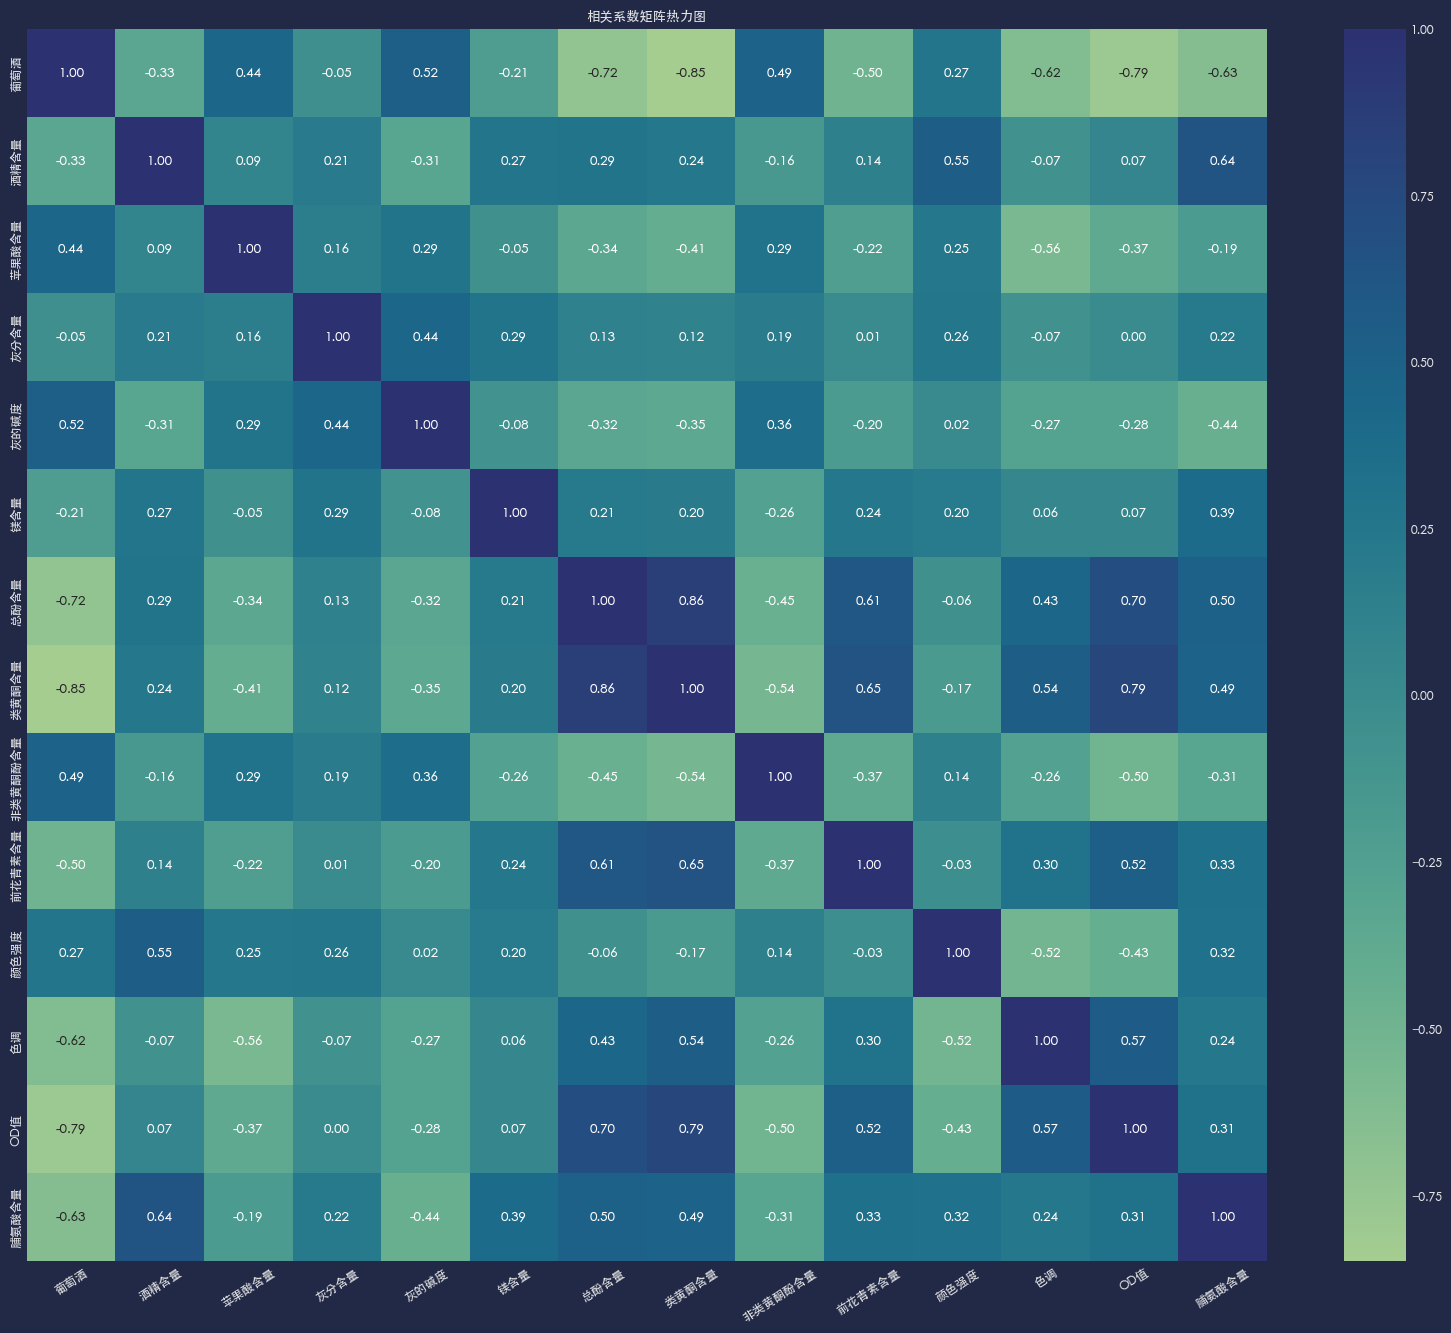

In [5]:
## 3.1
ticknames = [
    "葡萄酒",
    "酒精含量",
    "苹果酸含量",
    "灰分含量",
    "灰的碱度",
    "镁含量",
    "总酚含量",
    "类黄酮含量",
    "非类黄酮酚含量",
    "前花青素含量",
    "颜色强度",
    "色调",
    "OD值",
    "脯氨酸含量",
]

correlation_matrix = wine_data.corr()

plt.figure(figsize=(20, 16))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=ticknames,
    yticklabels=ticknames,
    cmap="crest",
)

plt.title("相关系数矩阵热力图")
plt.xticks(rotation=33)

plt.show()

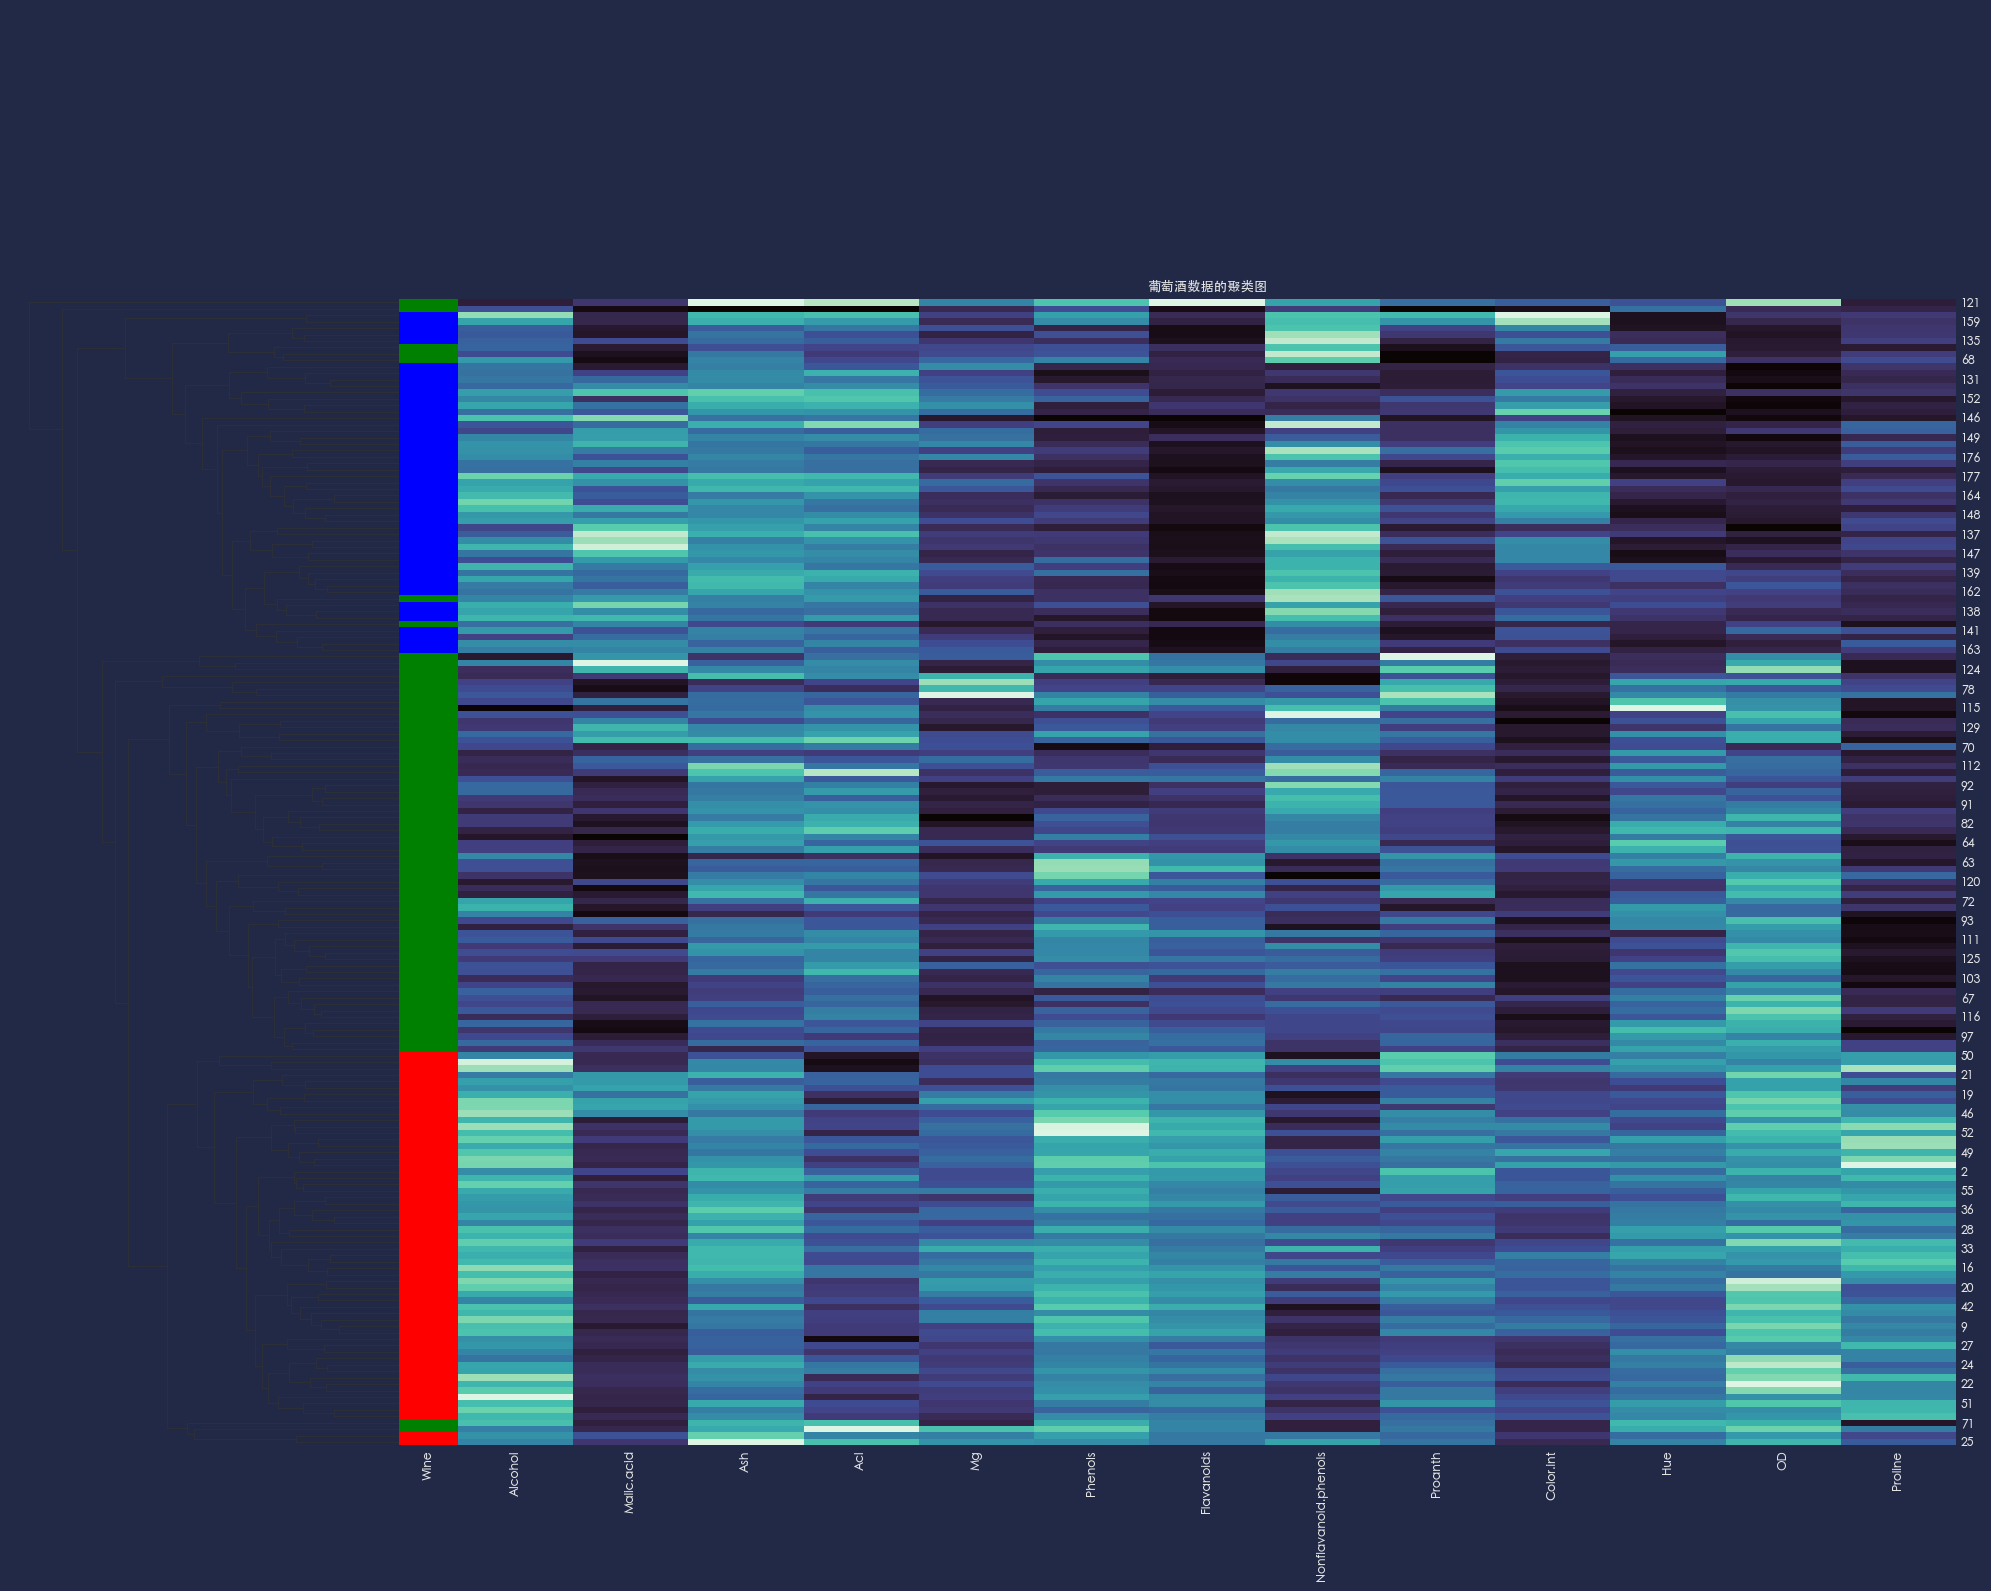

In [6]:
## 3.2
clustermap = sns.clustermap(
    wine_data.drop("Wine", axis=1),
    col_cluster=False,
    cbar_pos=None,
    cmap="mako",
    figsize=(20, 16),
    row_colors=wine_data["Wine"].map({1: "r", 2: "g", 3: "b"}),
    standard_scale=1,
)

plt.title("葡萄酒数据的聚类图")

plt.show()

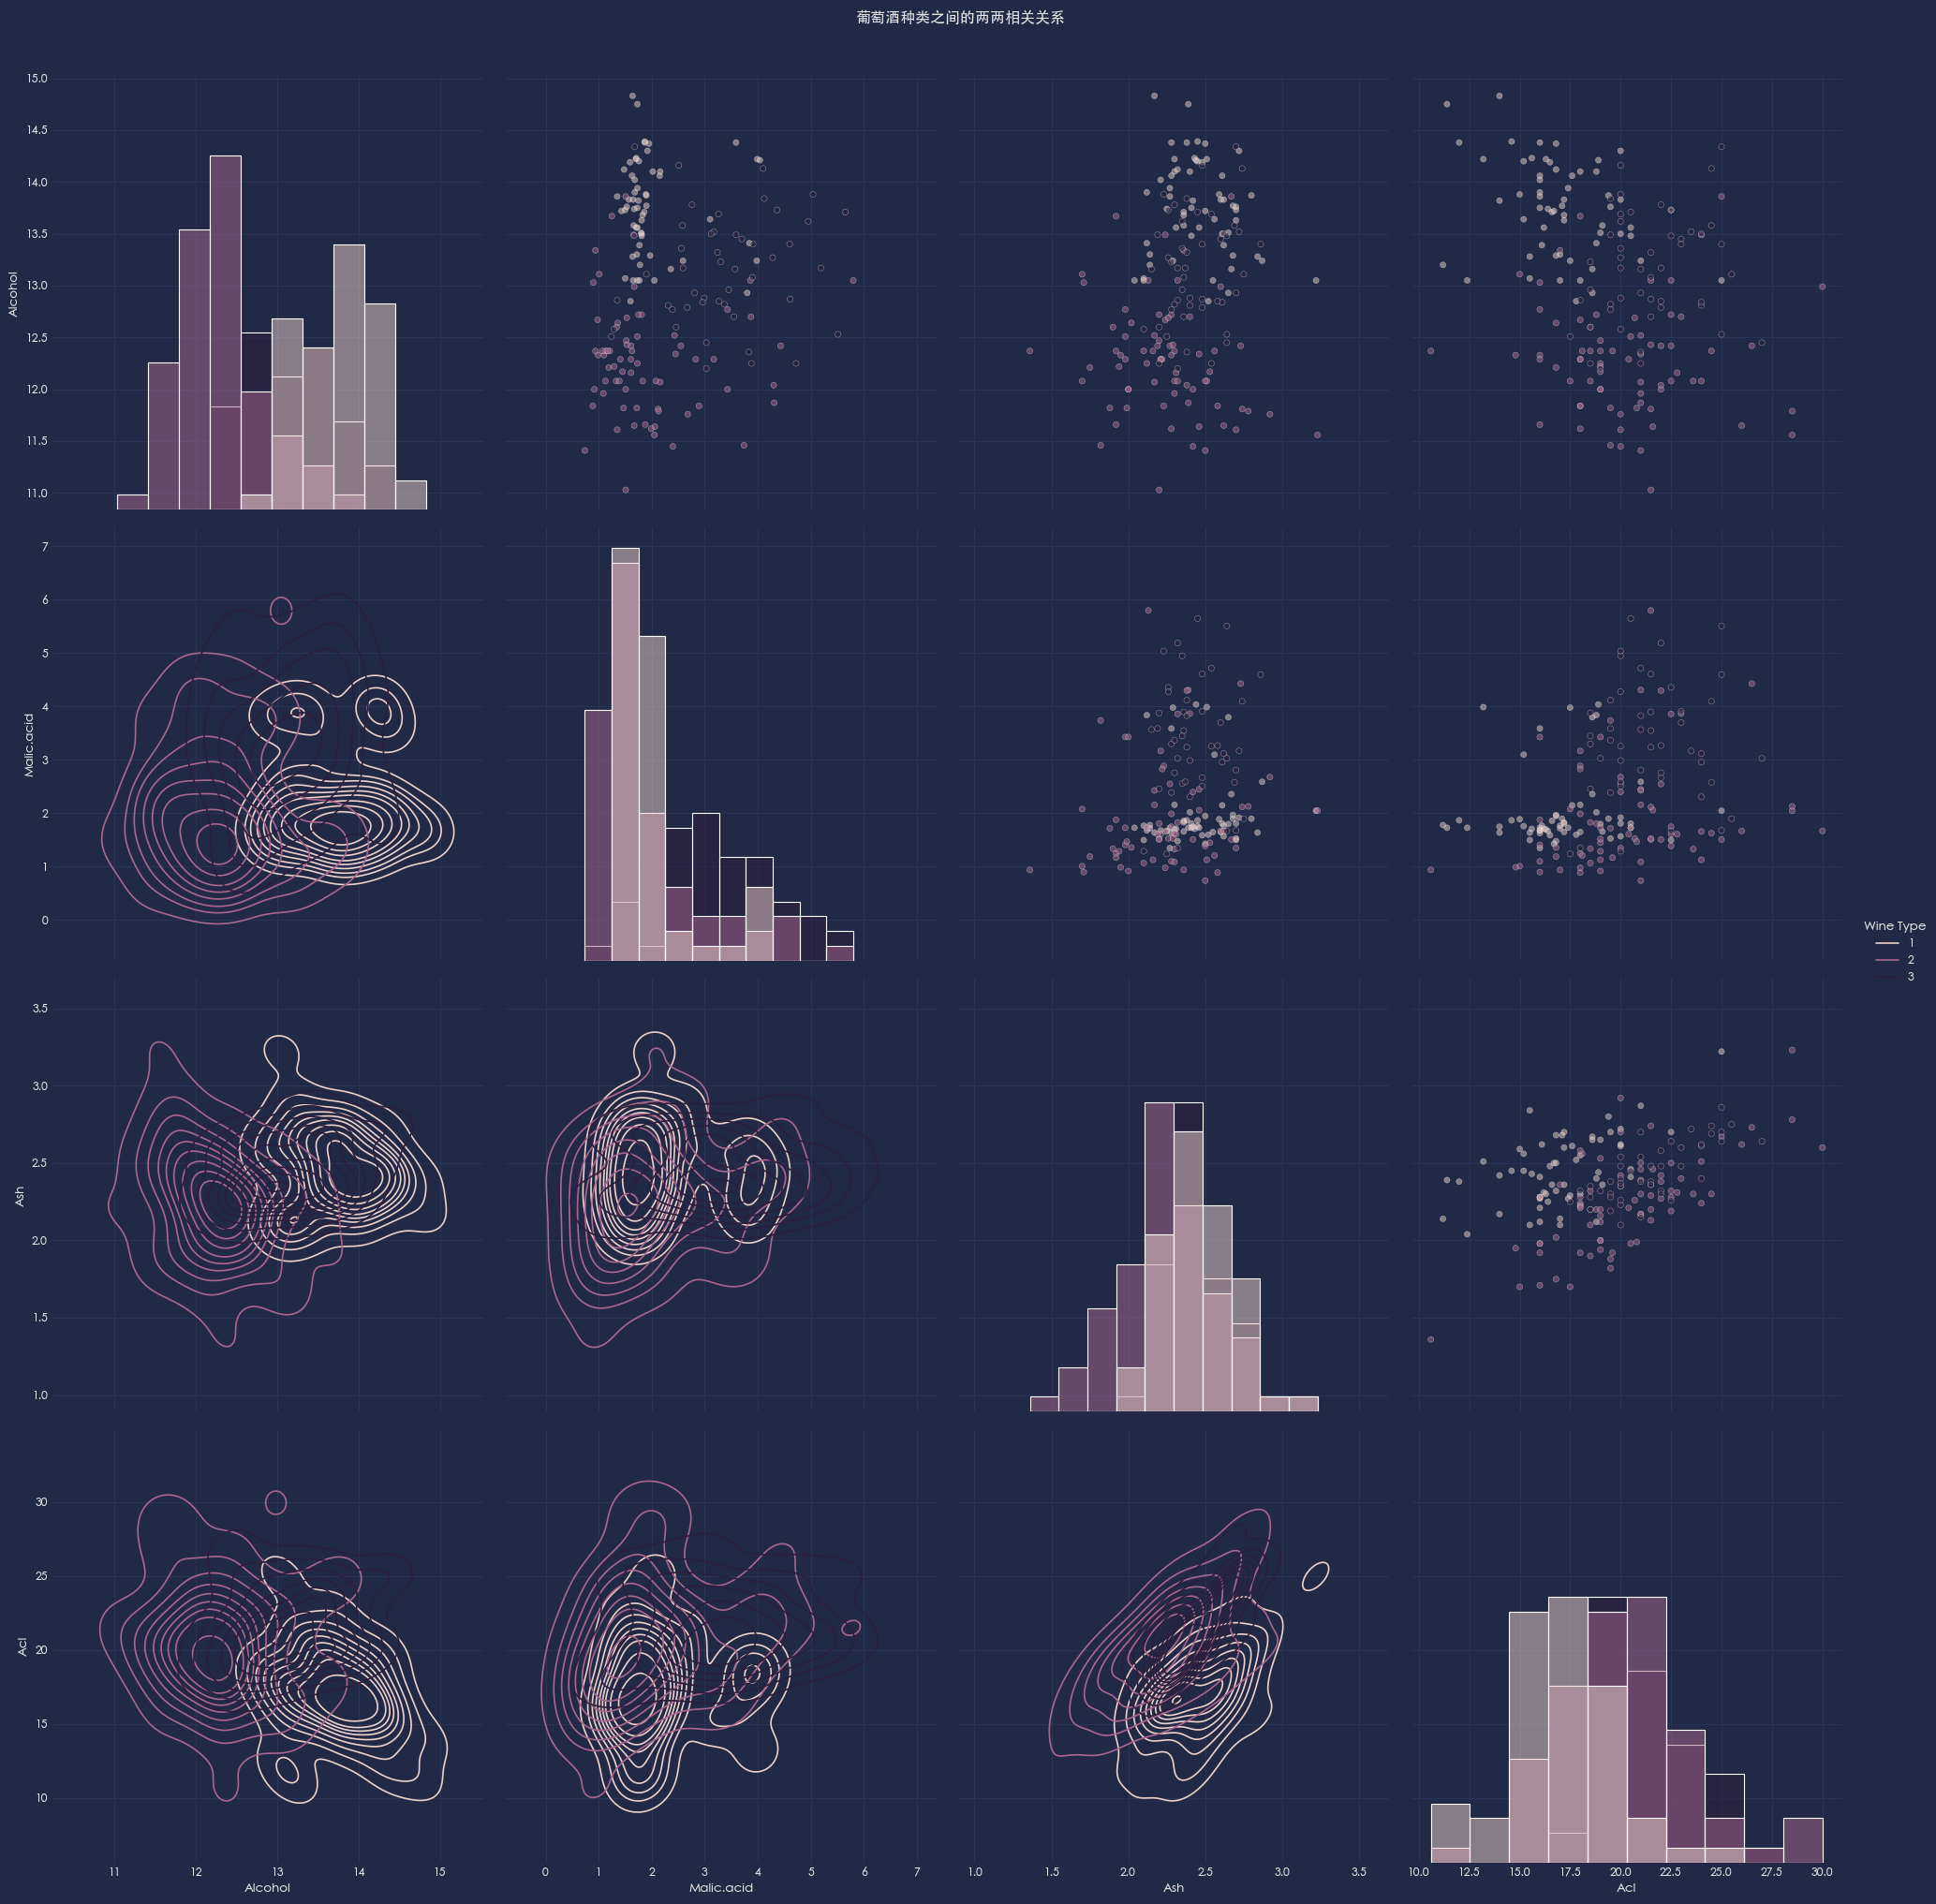

In [7]:
## 3.3

pairplot_data = wine_data[["Alcohol", "Malic.acid", "Ash", "Acl", "Wine"]]
g = sns.PairGrid(pairplot_data, hue="Wine", height=5)

g.map_diag(sns.histplot, kde_kws={"color": "k"}, color="b", bins=10)
g.map_upper(sns.scatterplot, alpha=0.5, s=20)
g.map_lower(sns.kdeplot, cmap="Blues")

plt.suptitle("葡萄酒种类之间的两两相关关系", y=1.02)

g.add_legend(title="Wine Type")

plt.show()

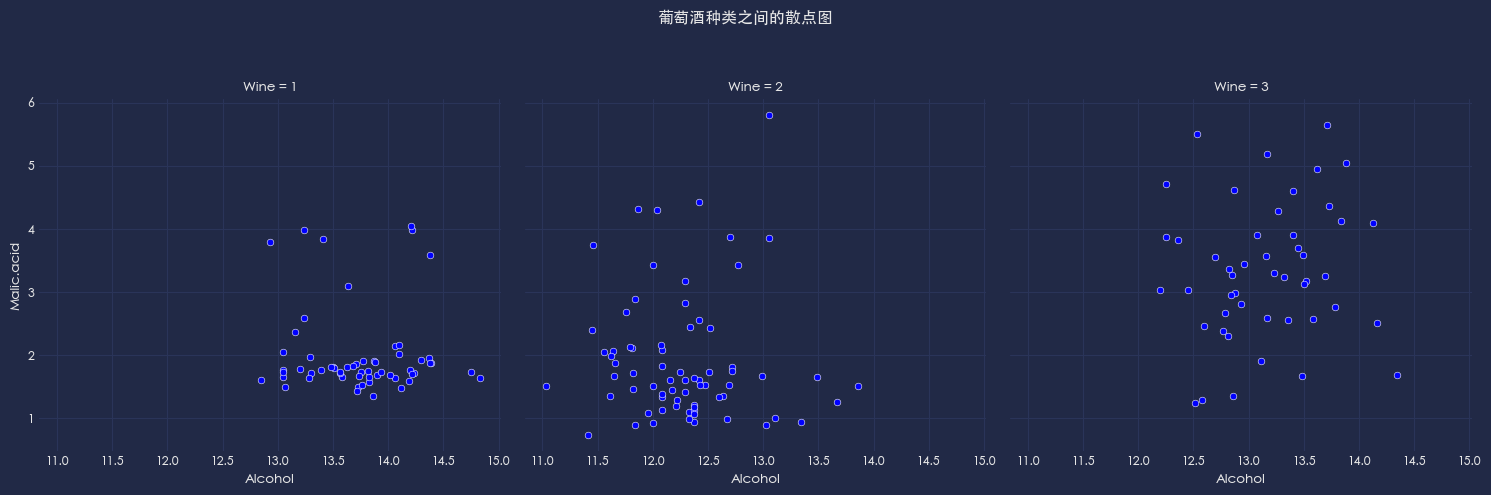

In [8]:
## 3.4
g = sns.FacetGrid(wine_data, col="Wine", height=5)

g.map(sns.scatterplot, "Alcohol", "Malic.acid", marker="o", color="b")
g.set_axis_labels("Alcohol", "Malic.acid")

plt.subplots_adjust(top=0.8)

g.fig.suptitle("葡萄酒种类之间的散点图")

plt.show()

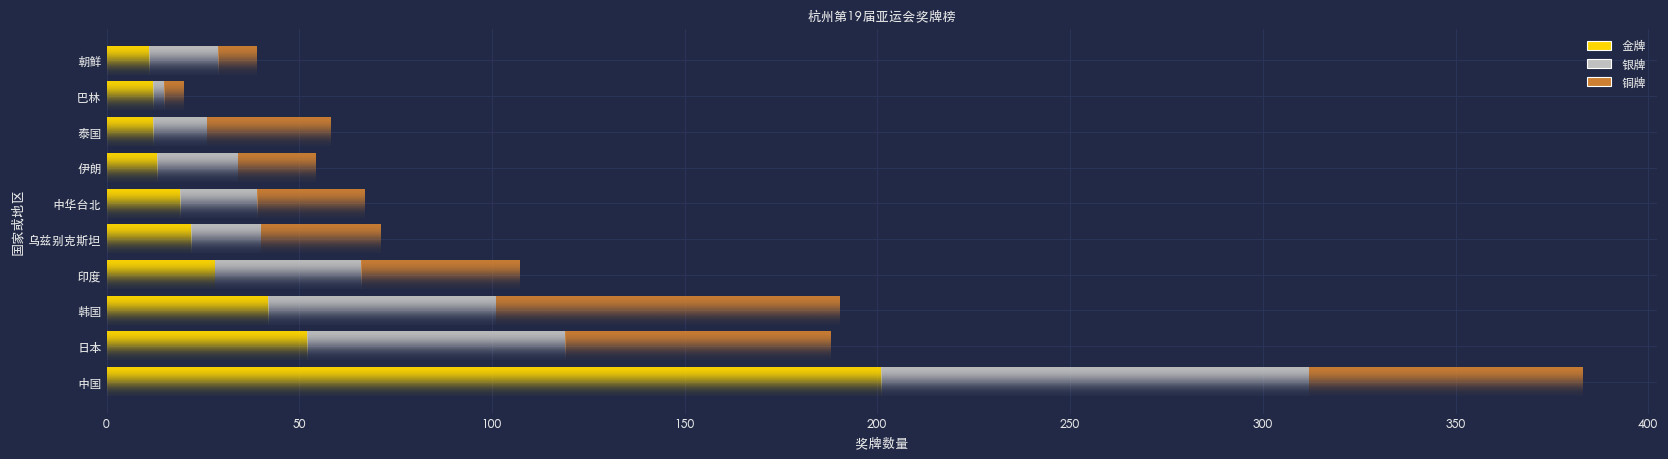

In [9]:
# 4
## 4.1
countries = ["中国", "日本", "韩国", "印度", "乌兹别克斯坦", "中华台北", "伊朗", "泰国", "巴林", "朝鲜"]
gold = [201, 52, 42, 28, 22, 19, 13, 12, 12, 11]
silver = [111, 67, 59, 38, 18, 20, 21, 14, 3, 18]
bronze = [71, 69, 89, 41, 31, 28, 20, 32, 5, 10]

plt.figure(figsize=(20, 5))
bars1 = plt.barh(countries, gold, color="gold")

bars2 = plt.barh(countries, silver, left=gold, color="silver")

bars3 = plt.barh(countries, bronze, left=np.add(gold, silver), color="#cd7f32")

mplcyberpunk.add_bar_gradient(bars=bars1)
mplcyberpunk.add_bar_gradient(bars=bars2)
mplcyberpunk.add_bar_gradient(bars=bars3)

plt.xlabel("奖牌数量")
plt.ylabel("国家或地区")
plt.title("杭州第19届亚运会奖牌榜")
plt.legend(["金牌", "银牌", "铜牌"])

plt.show()

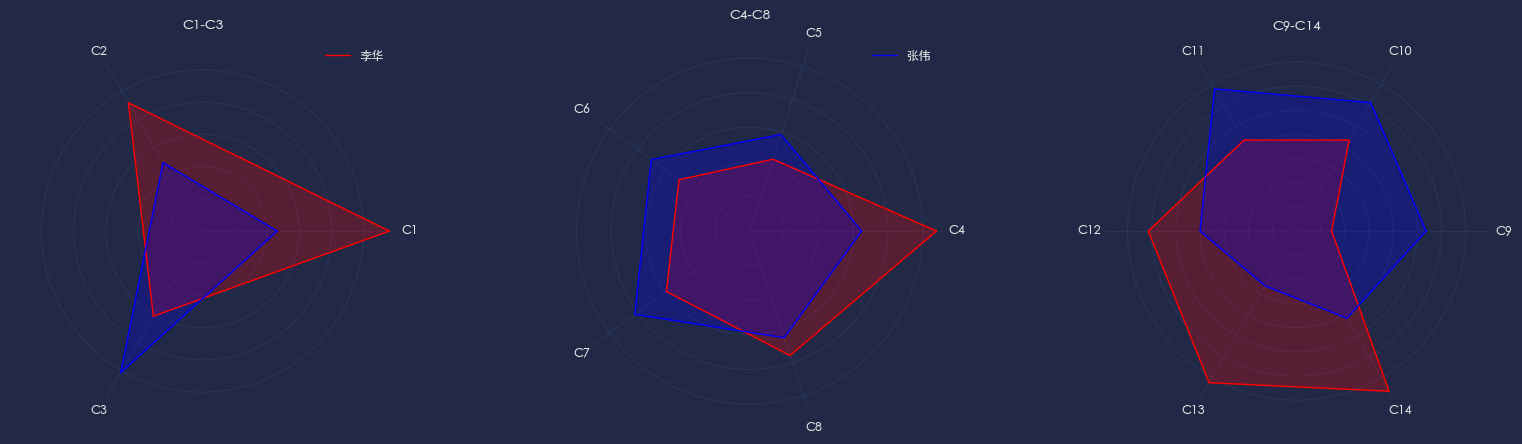

In [10]:
## 4.2
data1 = {
    "Name": "李华",
    "C1-C3": [29.00, 23.00, 15.26],
    "C4-C8": [27.00, 10.91, 12.60, 14.85, 18.90],
    "C9-C14": [1.45, 4.35, 4.35, 6.14, 7.25, 7.66],
}

data2 = {
    "Name": "张伟",
    "C1-C3": [11.60, 12.26, 25.39],
    "C4-C8": [16.20, 14.66, 17.55, 20.49, 16.20],
    "C9-C14": [5.36, 6.14, 6.80, 4.00, 2.62, 4.17],
}


def create_radar_chart(axes, data, color, title, labels, legend_label=None):
    num_vars = len(data)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    data += data[:1]
    angles += angles[:1]

    (line,) = axes.plot(angles, data, color=color, linewidth=1)
    axes.fill(angles, data, color=color, alpha=0.25)

    axes.set_title(title)

    axes.set_xticks(angles[:-1])
    axes.set_xticklabels(labels)
    axes.set_yticklabels([])

    if legend_label is not None:
        axes.legend([line], [legend_label], loc="upper right")


fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection="polar"), ncols=3)

create_radar_chart(ax[0], data1["C1-C3"], "red", "C1-C3", ["C1", "C2", "C3"], "李华")
create_radar_chart(
    ax[1], data1["C4-C8"], "red", "C4-C8", ["C4", "C5", "C6", "C7", "C8"]
)
create_radar_chart(
    ax[2], data1["C9-C14"], "red", "C9-C14", ["C9", "C10", "C11", "C12", "C13", "C14"]
)
create_radar_chart(ax[0], data2["C1-C3"], "blue", "C1-C3", ["C1", "C2", "C3"])
create_radar_chart(
    ax[1], data2["C4-C8"], "blue", "C4-C8", ["C4", "C5", "C6", "C7", "C8"], "张伟"
)
create_radar_chart(
    ax[2], data2["C9-C14"], "blue", "C9-C14", ["C9", "C10", "C11", "C12", "C13", "C14"]
)

plt.show()

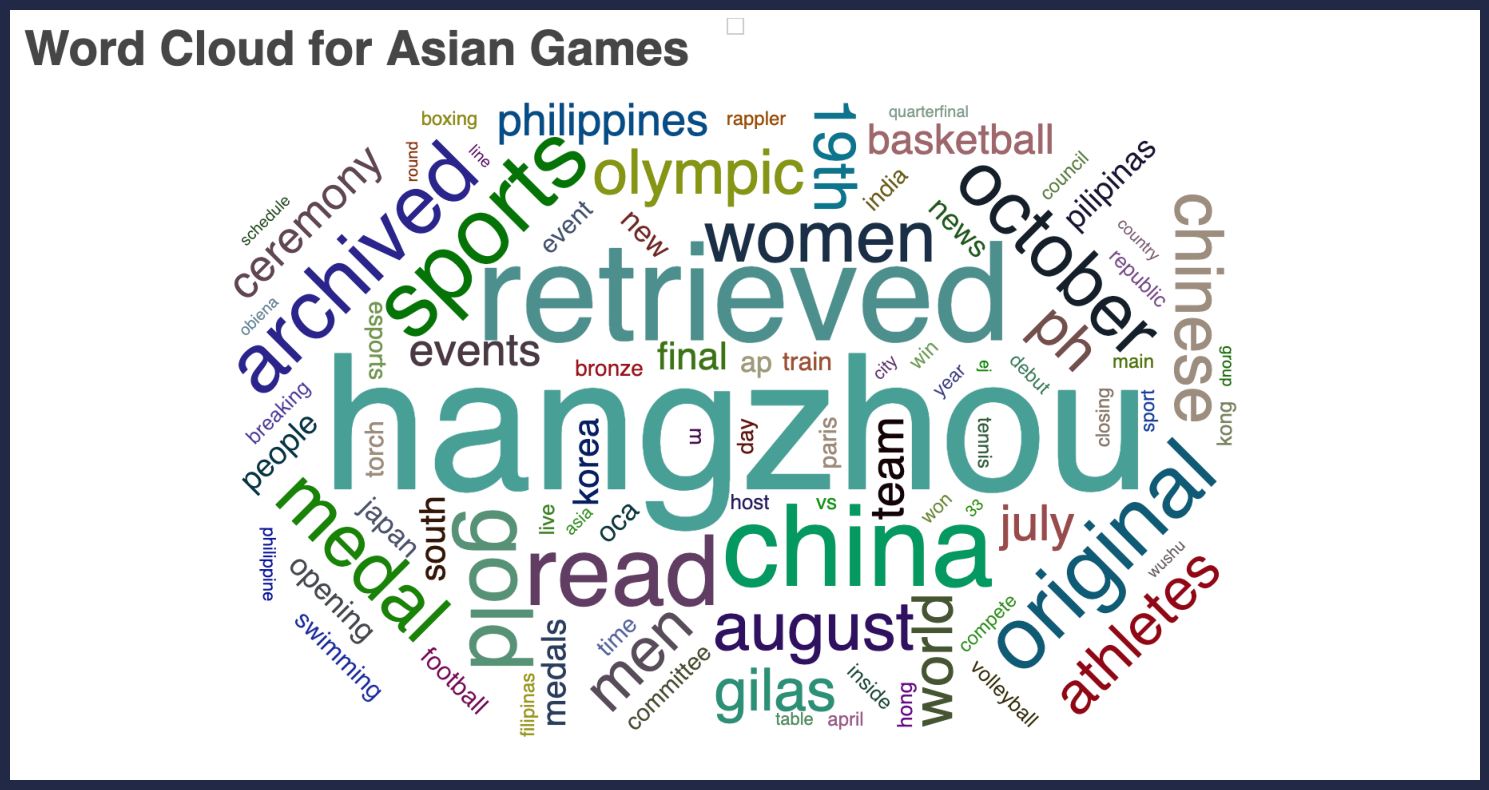

In [11]:
## 4.3
import re

import spacy

from collections import Counter

from pyecharts.charts import WordCloud as EchartWordCloud
from pyecharts import options as opts

nlp = spacy.load("en_core_web_sm")
stop_words = set(nlp.Defaults.stop_words)

with open("asaingames.txt", "r", encoding="utf-8") as file:
    text = file.read()


def preprocess_text(text):
    doc = nlp(text)

    filtered_words = [
        token.text
        for token in doc
        if not token.text.isnumeric()
        and token.text.lower() not in stop_words
        and not token.is_punct
    ]

    filtered_words = [re.sub(r"[^\w\s]", "", word).lower() for word in filtered_words]

    return filtered_words


filtered_words = preprocess_text(text)

word_freq = Counter(filtered_words)

# min_freq = min(word_freq.values())
max_freq = max(word_freq.values())

wordcloud = (
    EchartWordCloud()
    .add(
        "Word Cloud",
        word_freq.most_common(100),
        word_size_range=[10, max_freq],
        shape="circle",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="Word Cloud for Asian Games",
            title_textstyle_opts=opts.TextStyleOpts(font_size=30),
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )
)
wordcloud.render("wordcloud.html")

img = mpimg.imread("wordcloud.jpeg")

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis("off")

plt.show()

In [12]:
# 5
sns.set_theme(style="whitegrid", palette="Set3", color_codes=True)
df = pd.read_csv("housing.csv")

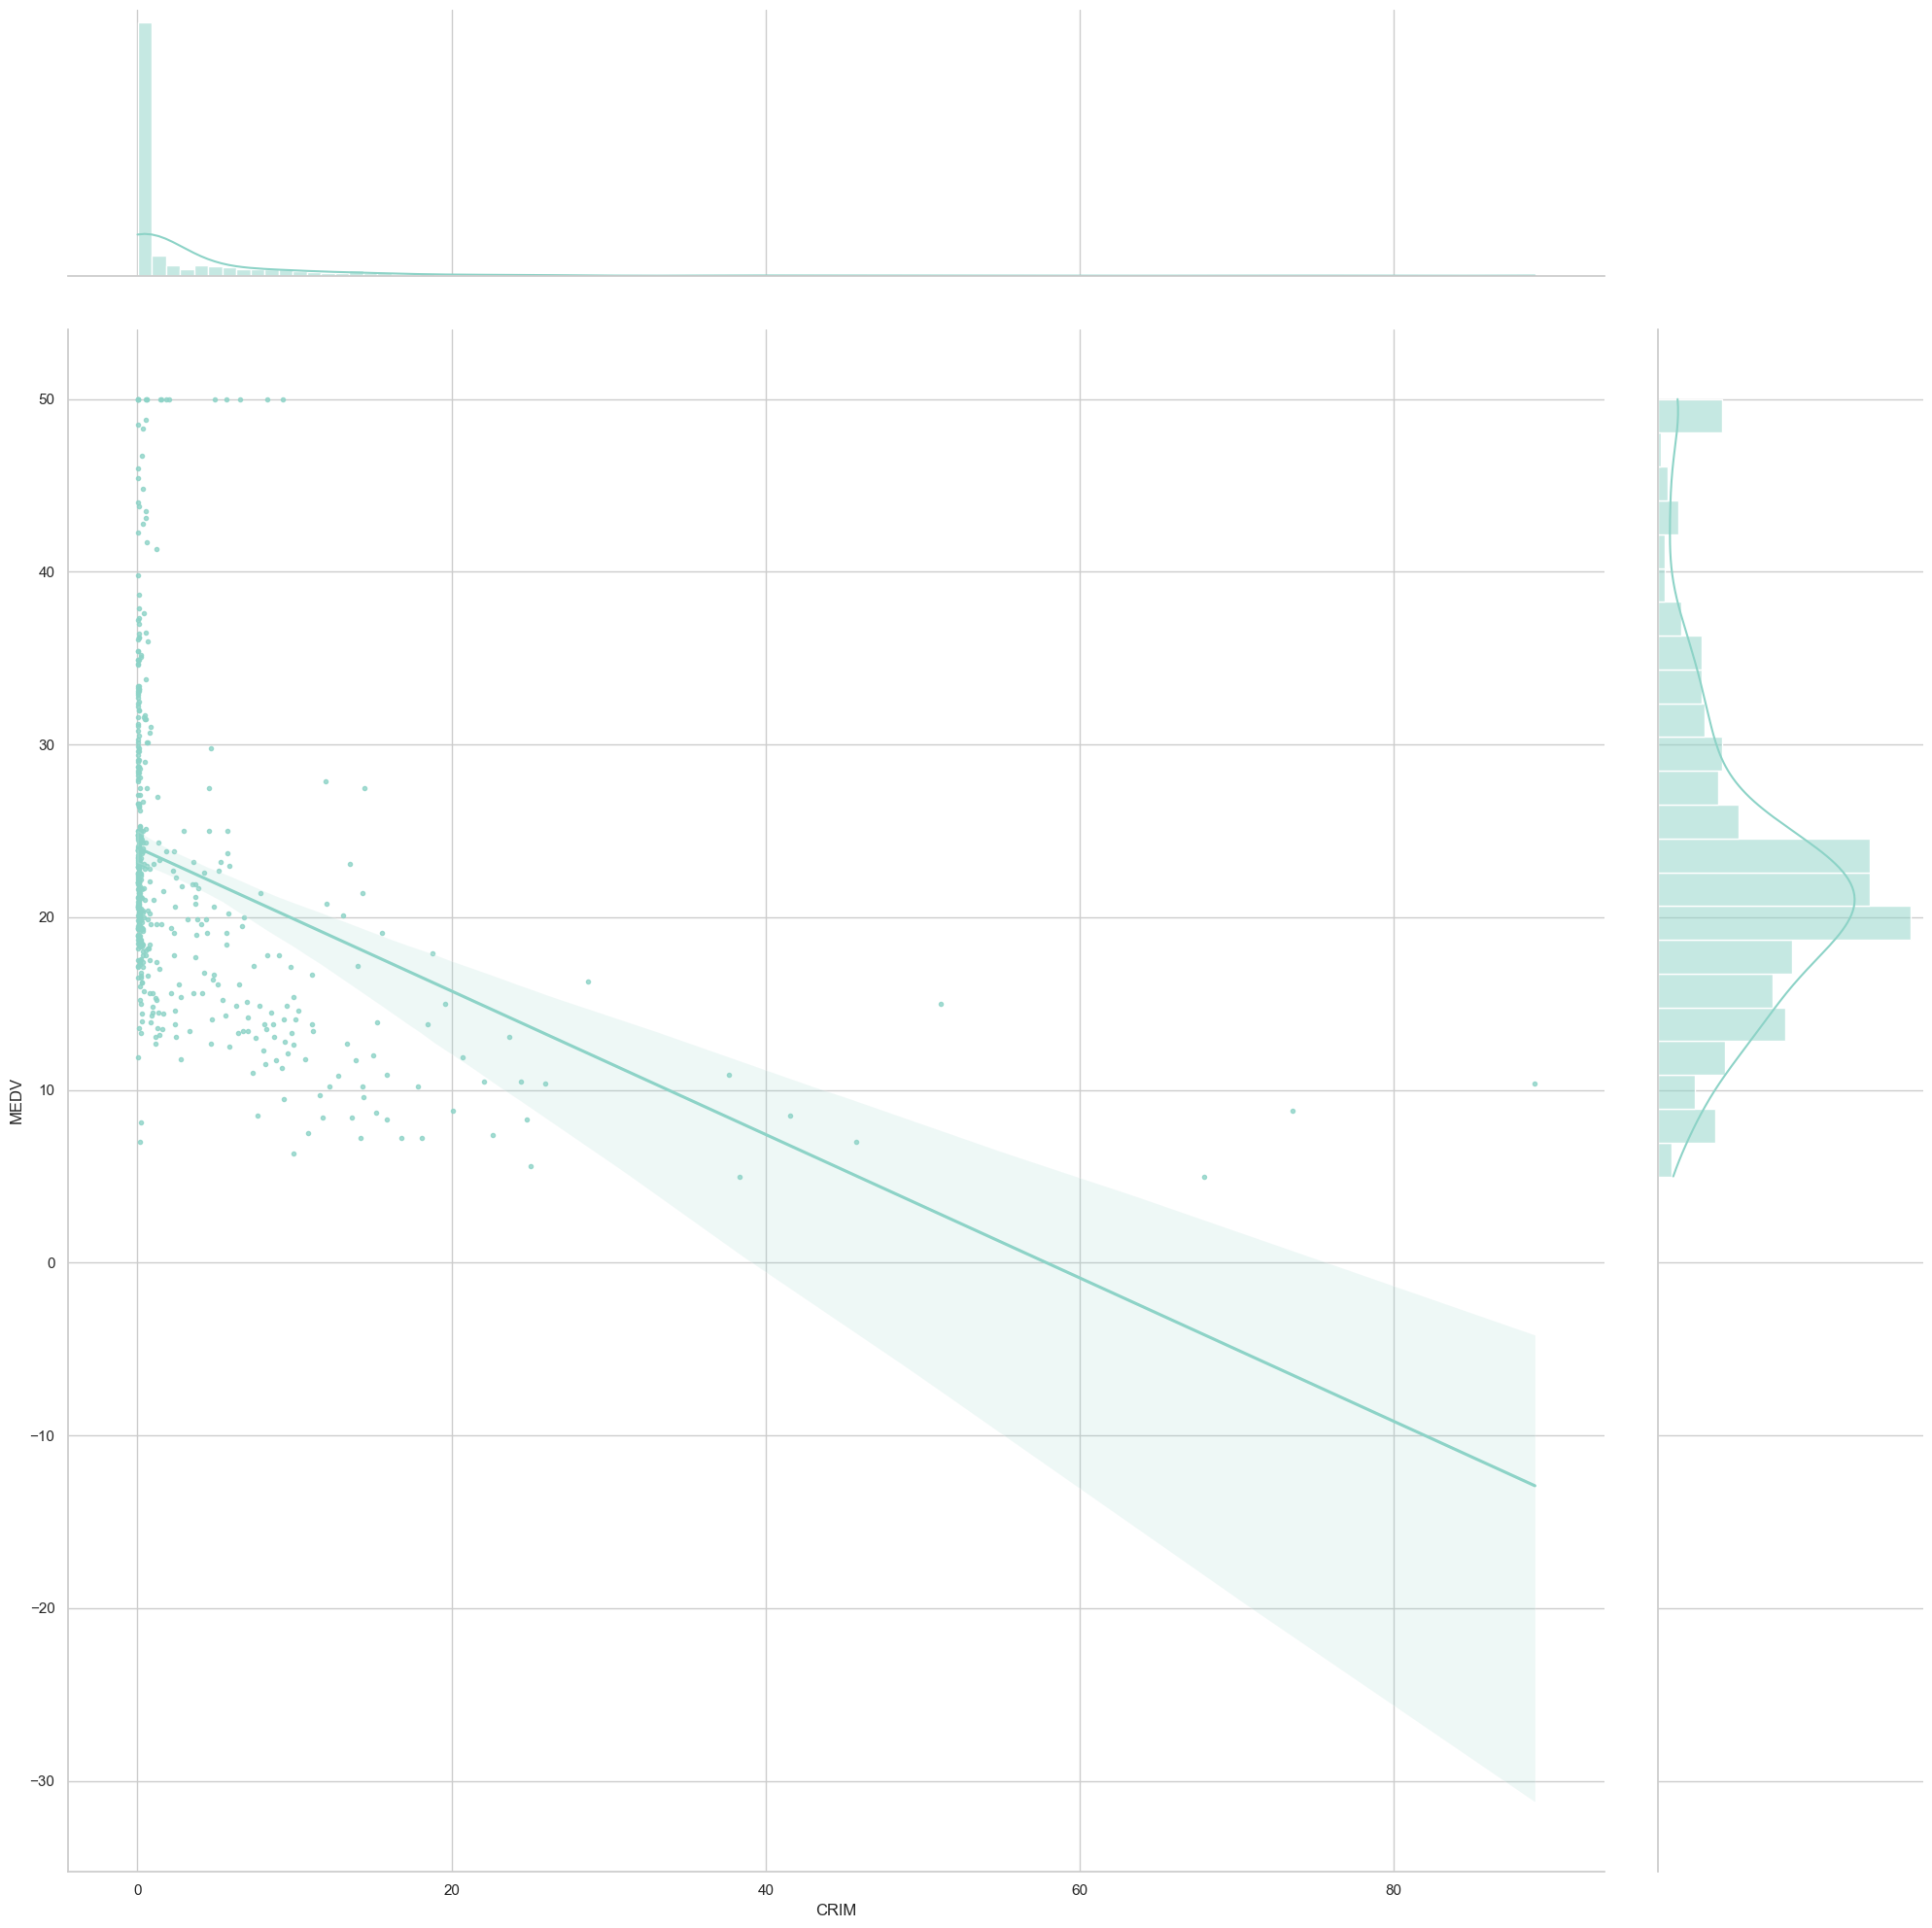

In [13]:
## 5.1
sns.jointplot(x="CRIM", y="MEDV", data=df, height=20, kind="reg", marker=".")
plt.show()

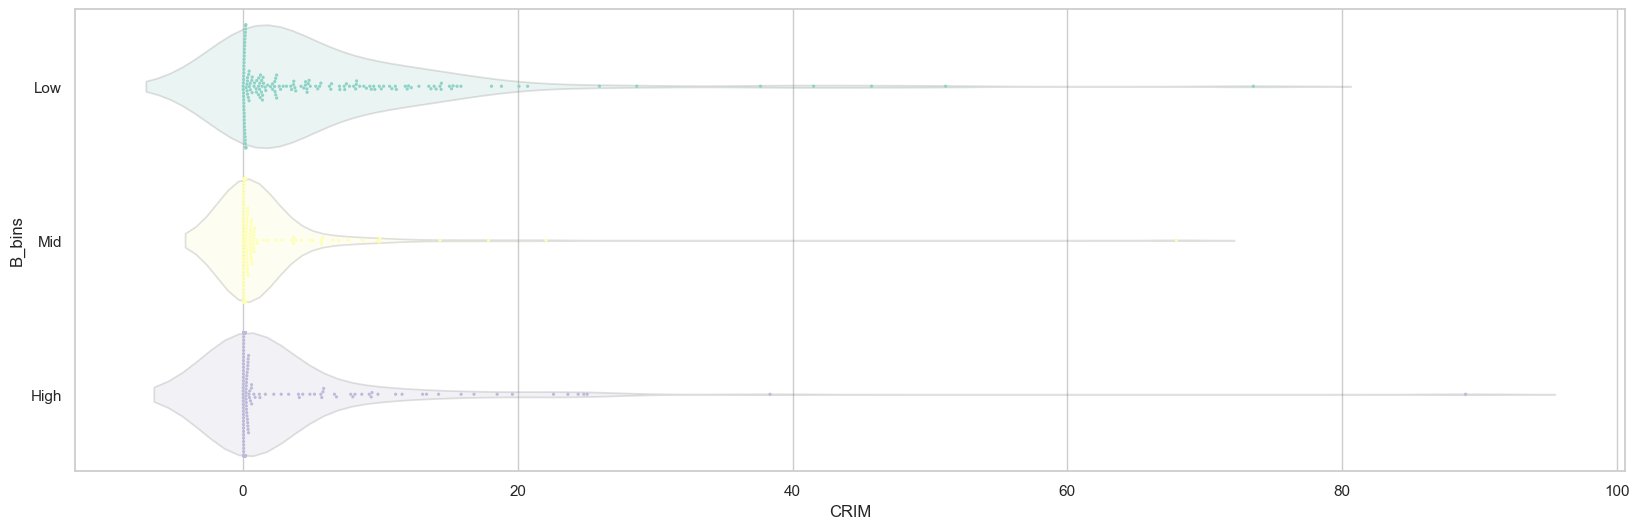

In [14]:
## 5.2
bins = [df["B"].min(), df["B"].quantile(0.33), df["B"].quantile(0.67), df["B"].max()]
labels = ["Low", "Mid", "High"]

df["B_bins"] = pd.cut(df["B"], bins=bins, labels=labels)

plt.figure(figsize=(20, 6))

sns.violinplot(
    y="B_bins", x="CRIM", data=df, inner=None, alpha=0.2, hue="B_bins", legend=False
)
sns.swarmplot(y="B_bins", x="CRIM", data=df, size=2.31312, hue="B_bins", legend=False)

plt.show()

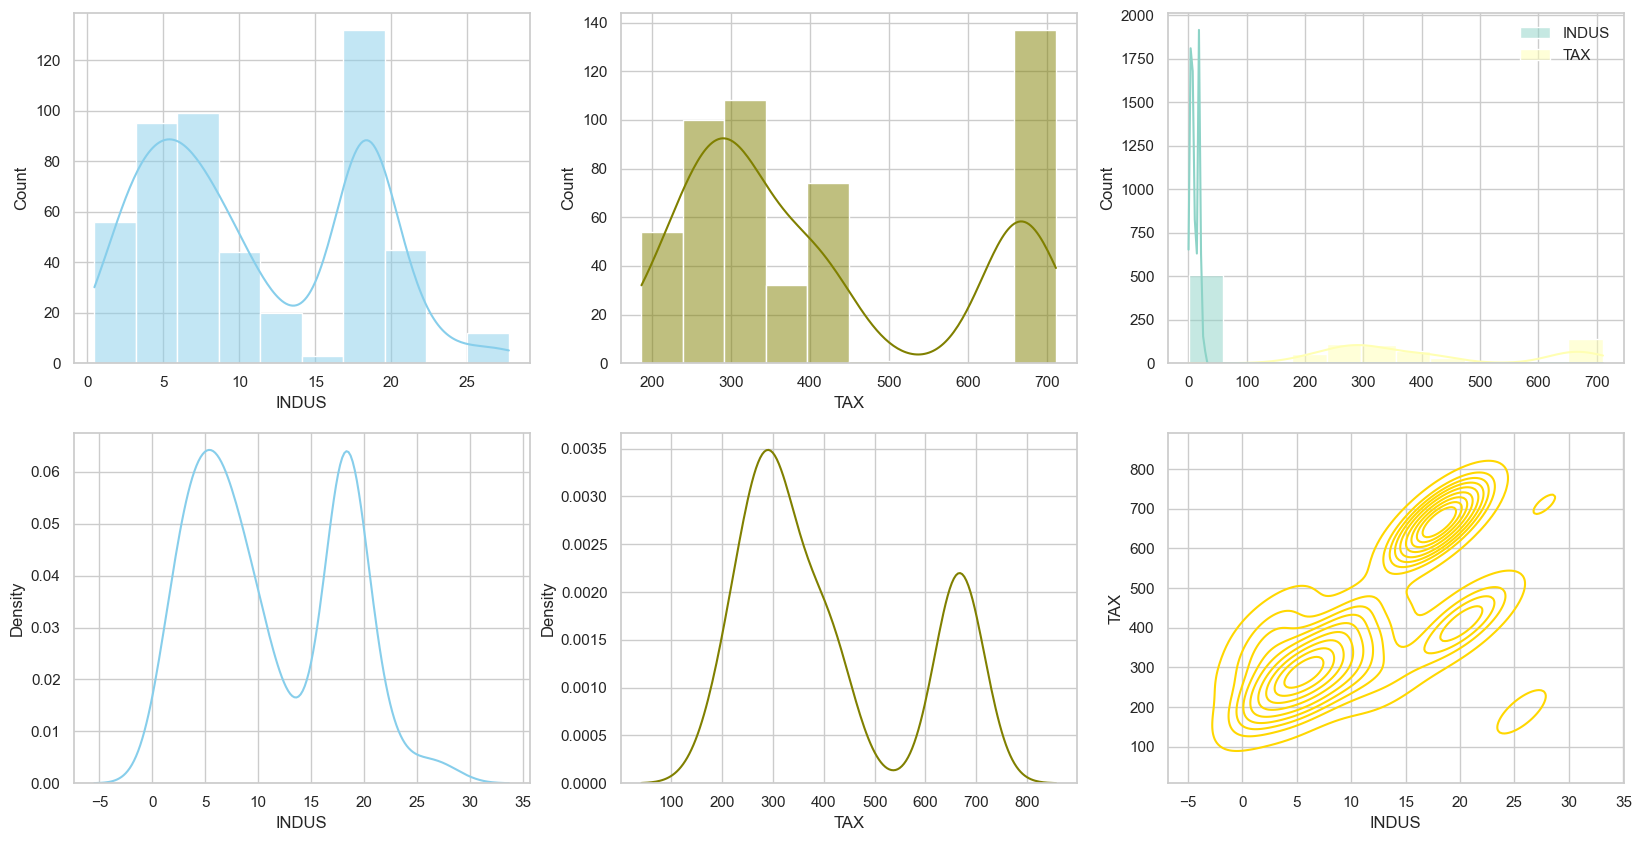

In [15]:
## 5.3
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(df["INDUS"], kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(df["TAX"], kde=True, color="olive", ax=axs[0, 1])
sns.histplot(df[["INDUS", "TAX"]], kde=True, color="gold", ax=axs[0, 2])
sns.kdeplot(df["INDUS"], color="skyblue", ax=axs[1, 0])
sns.kdeplot(df["TAX"], color="olive", ax=axs[1, 1])
sns.kdeplot(x=df["INDUS"], y=df["TAX"], color="gold", ax=axs[1, 2])

plt.show()

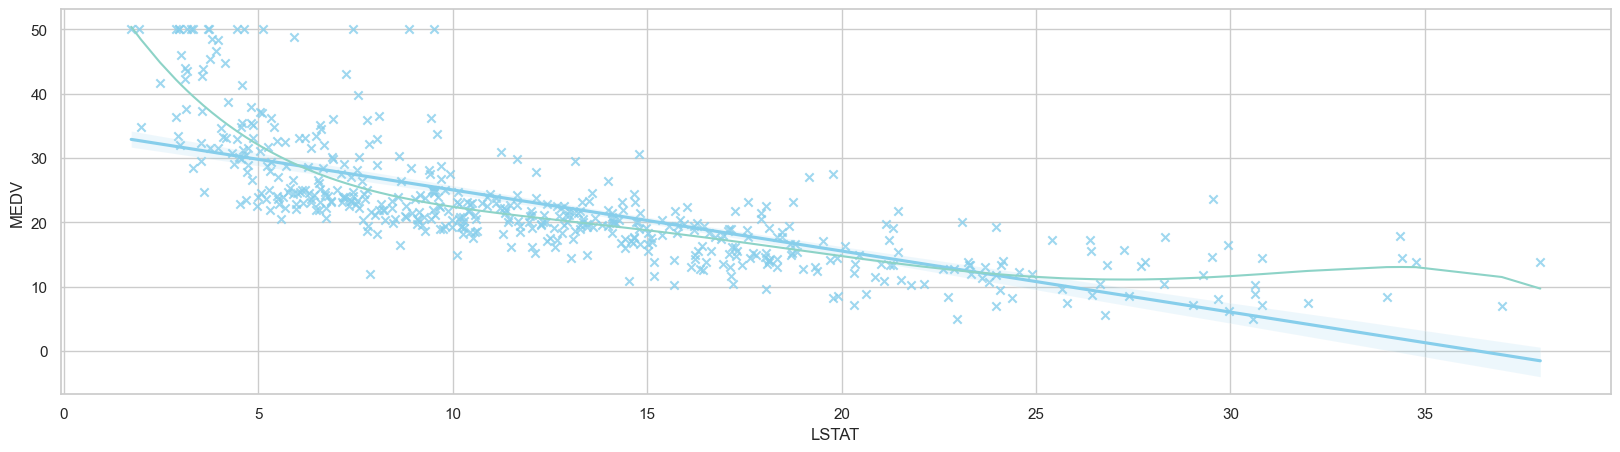

In [16]:
## 5.4
plt.figure(figsize=(20, 5))

from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=5)
poly_features = poly.fit_transform(df["LSTAT"].to_numpy().reshape(-1, 1))

reg = LinearRegression()
reg.fit(poly_features, df["MEDV"])

pred = reg.predict(poly_features)

sns.regplot(x="LSTAT", y="MEDV", data=df, marker="x", color="skyblue")
sns.lineplot(x=df["LSTAT"], y=pred)

plt.show()

In [17]:
# 6
sns.set_theme(style="darkgrid", palette="Set2", context="paper")

plt.style.use("cyberpunk")
plt.rcParams["font.sans-serif"] = font_path

df = pd.read_csv("flights.csv")

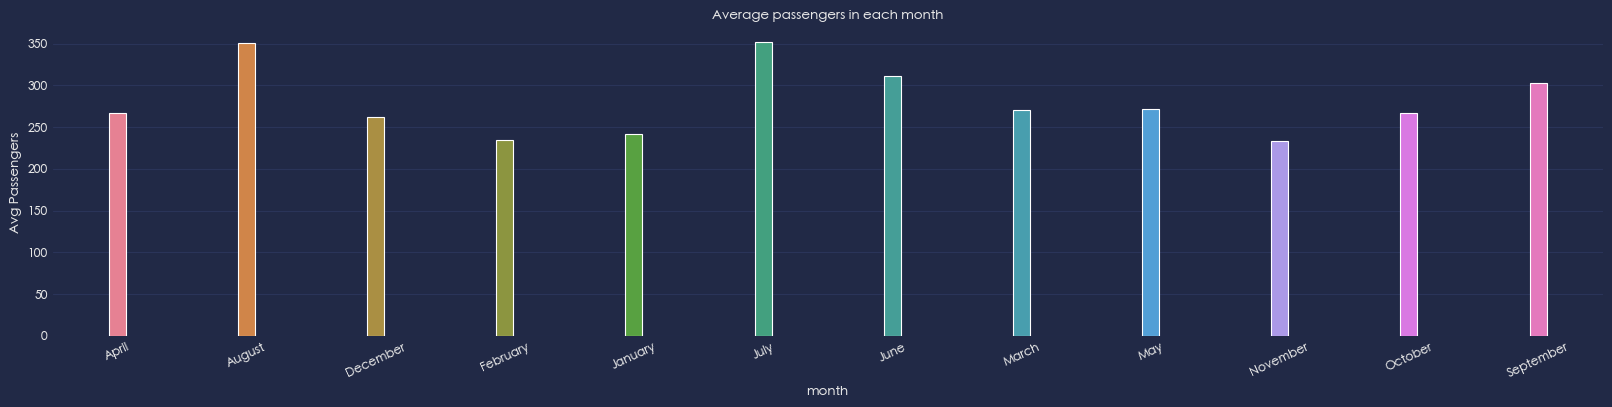

In [18]:
## 6.1
data = df.groupby("month")["passengers"].mean()

fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.barplot(x=data.index, y=data.values, hue=data.index, width=0.13113)

ax.set_title("Average passengers in each month")
ax.set_ylabel("Avg Passengers")
ax.set_xticks(ticks=data.index)
ax.set_xticklabels(labels=data.index, rotation=25)

plt.show()

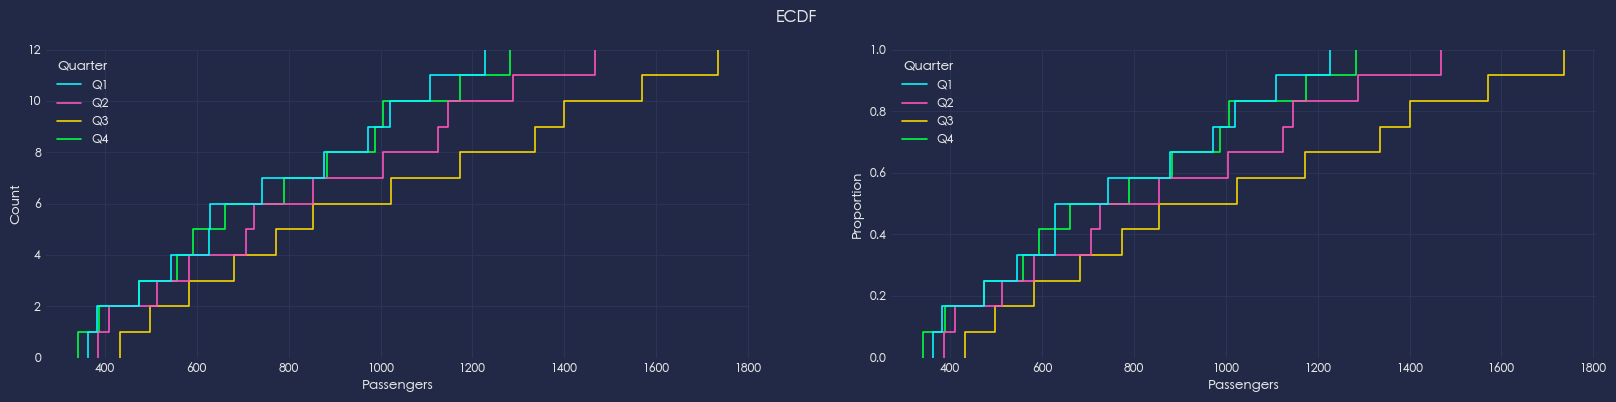

In [19]:
## 6.2
df["Quarter"] = df["month"].map(
    lambda x: "Q1"
    if x in ["January", "February", "March"]
    else "Q2"
    if x in ["April", "May", "June"]
    else "Q3"
    if x in ["July", "August", "September"]
    else "Q4"
)
df["Quarter"] = df["year"].astype(str) + df["Quarter"]

data = df.groupby("Quarter")["passengers"].sum()
data.index = data.index.map(lambda x: x[-2:])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

sns.ecdfplot(x=data.values, hue=data.index, stat="count", ax=axes[0])

axes[0].set_ylabel("Count")
axes[0].set_xlabel("Passengers")

sns.ecdfplot(x=data.values, hue=data.index, stat="proportion", ax=axes[1])

axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Passengers")

plt.suptitle("ECDF")

plt.show()

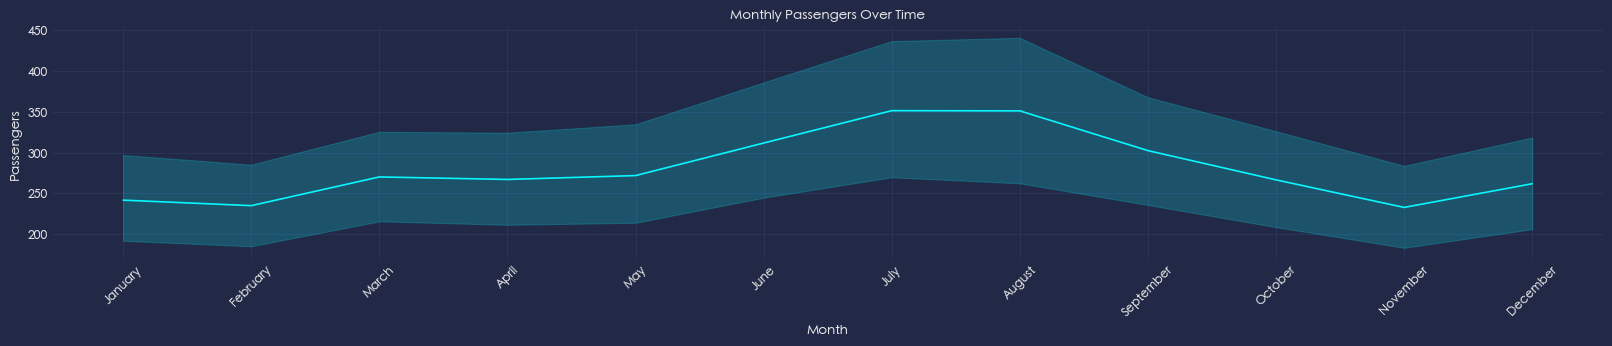

In [20]:
## 6.3
plt.figure(figsize=(20, 3))

sns.lineplot(data=df, x="month", y="passengers")

plt.title("Monthly Passengers Over Time")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.xticks(rotation=45)

plt.show()